In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
from itertools import product
import pickle

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', train=True)
MNIST_test = torchvision.datasets.MNIST('./', train=False)
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [5]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [6]:
resume = False

if resume: 
    with open('sgd_results.pkl', 'rb') as f:
        arr = pickle.load(f)
    test_accuracy_history_sgd = arr["acc"]
    test_history_sgd = arr["loss"]
else:
    test_accuracy_history_sgd, test_loss_history_sgd = {}, {}

In [7]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sgd:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(lenet5.parameters(), lr=learning_rate, weight_decay=weight_decay)
    batch_size = 100

    test_loss_history_sgd[key] = list()
    test_accuracy_history_sgd[key] = list()

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
        
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            optimizer.step()
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_sgd[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_sgd[key].append(accuracy)
    
    print(test_accuracy_history_sgd[(learning_rate, weight_decay)])
    with open('sgd_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd}, f)

[tensor(0.9674), tensor(0.9778), tensor(0.9830), tensor(0.9846), tensor(0.9854), tensor(0.9868), tensor(0.9874), tensor(0.9888), tensor(0.9902), tensor(0.9896), tensor(0.9888), tensor(0.9894), tensor(0.9884), tensor(0.9884), tensor(0.9888), tensor(0.9906), tensor(0.9900), tensor(0.9890), tensor(0.9912), tensor(0.9894)]
[tensor(0.9660), tensor(0.9774), tensor(0.9798), tensor(0.9828), tensor(0.9822), tensor(0.9836), tensor(0.9852), tensor(0.9856), tensor(0.9852), tensor(0.9884), tensor(0.9872), tensor(0.9884), tensor(0.9900), tensor(0.9892), tensor(0.9878), tensor(0.9904), tensor(0.9910), tensor(0.9896), tensor(0.9908), tensor(0.9900)]
[tensor(0.9742), tensor(0.9756), tensor(0.9808), tensor(0.9830), tensor(0.9846), tensor(0.9852), tensor(0.9896), tensor(0.9876), tensor(0.9884), tensor(0.9886), tensor(0.9906), tensor(0.9902), tensor(0.9902), tensor(0.9870), tensor(0.9894), tensor(0.9906), tensor(0.9904), tensor(0.9900), tensor(0.9912), tensor(0.9878)]
[tensor(0.9714), tensor(0.9780), tens

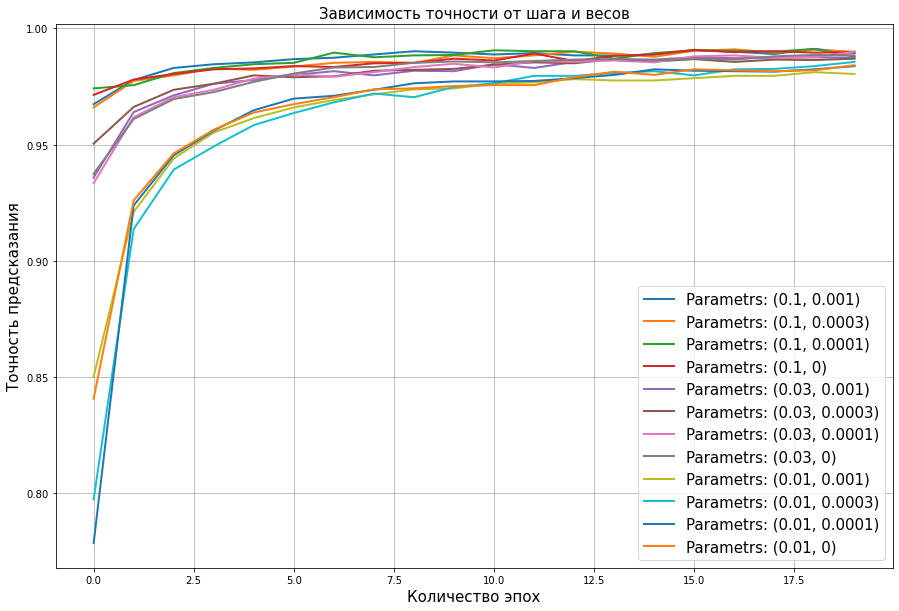

In [8]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for param, accuracy in test_accuracy_history_sgd.items():
    plt.plot(accuracy, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

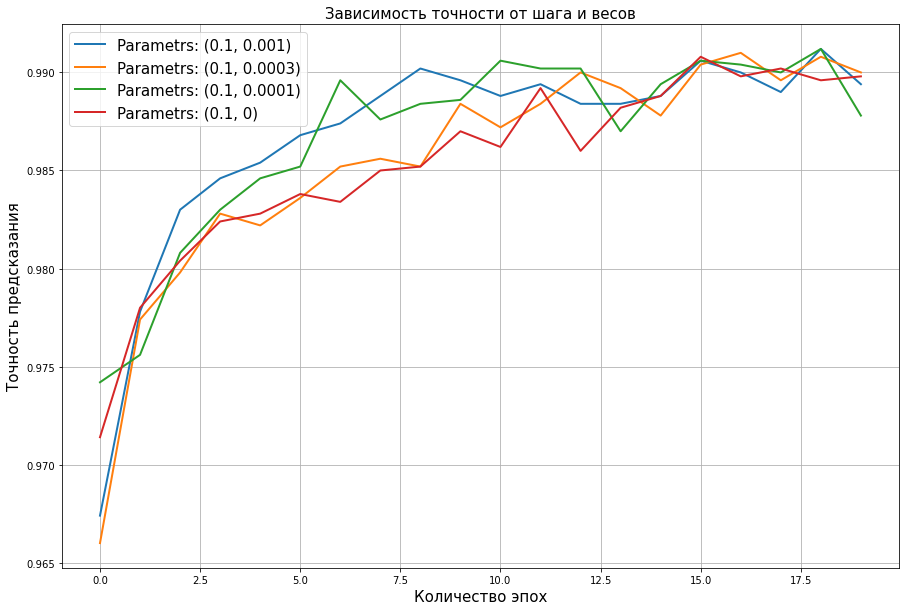

In [9]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.1], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(test_accuracy_history_sgd[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

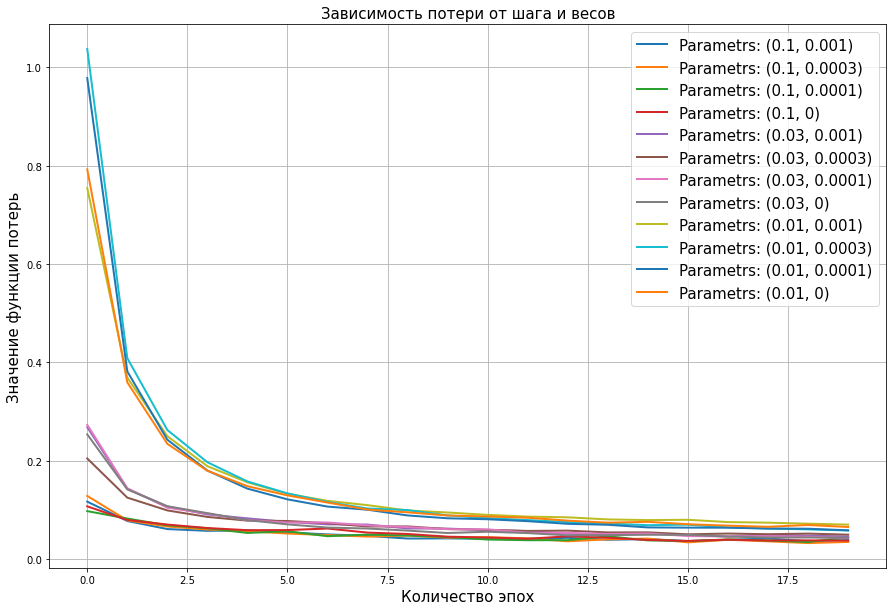

In [10]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
for param, loss in test_loss_history_sgd.items():
    plt.plot(loss, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

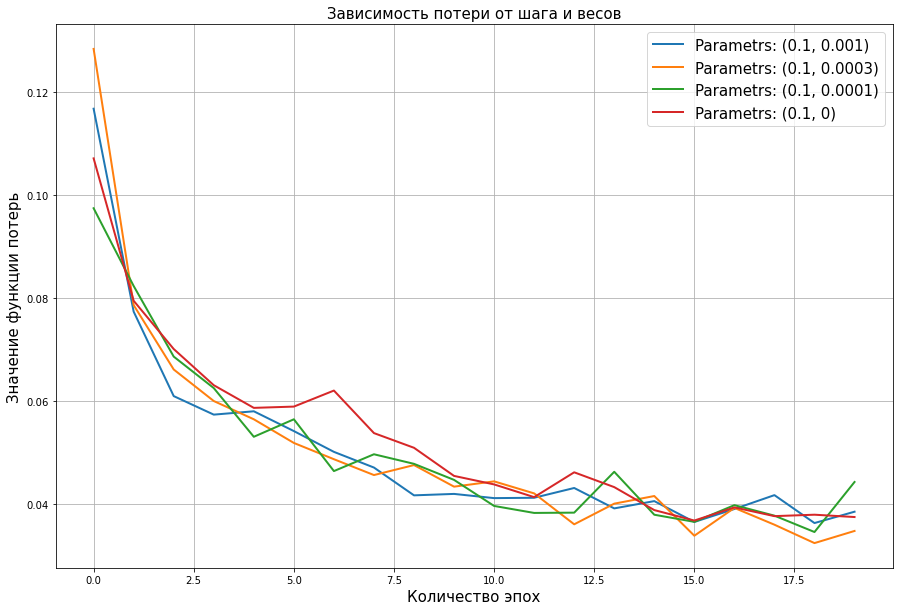

In [11]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
for  param in product([0.1], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(test_loss_history_sgd[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [21]:
test_accuracy_history_sgd[(0.1, 0)]

[tensor(0.8356),
 tensor(0.9256),
 tensor(0.9408),
 tensor(0.9530),
 tensor(0.9564),
 tensor(0.9586),
 tensor(0.9586),
 tensor(0.9650),
 tensor(0.9612),
 tensor(0.9620),
 tensor(0.9694),
 tensor(0.9682),
 tensor(0.9690),
 tensor(0.9708),
 tensor(0.9734),
 tensor(0.9712),
 tensor(0.9712),
 tensor(0.9744),
 tensor(0.9708),
 tensor(0.9742)]

In [12]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [13]:
lenet5 = LeNet5()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet5.parameters(), lr=0.01, weight_decay=0)
batch_size = 100

test_loss_history_sgd = list()
test_accuracy_history_sgd = list()

for epoch in range(20):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
            
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history_sgd.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_sgd.append(accuracy)

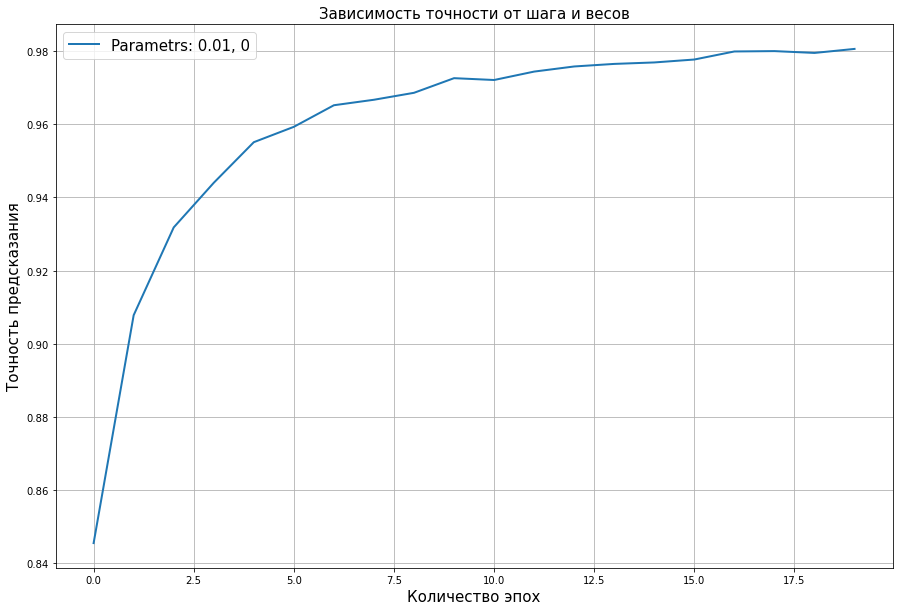

In [14]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
plt.plot(test_accuracy_history_sgd, label = "Parametrs: 0.01, 0", linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

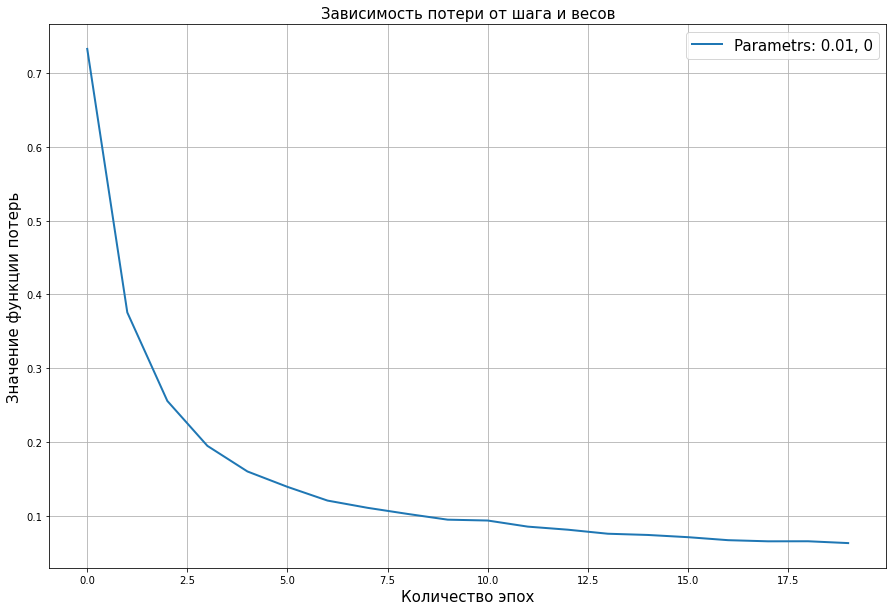

In [15]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.plot(test_loss_history_sgd, label = "Parametrs: 0.01, 0", linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [16]:
with open('results.pkl', 'wb') as f:
        pickle.dump({"sgd_acc": test_accuracy_history_sgd, "sgd_loss": test_loss_history_sgd}, f)